# 8-ary 3D Signal Simulation over AWGN Channel

This notebook simulates the transmission of 8-ary 3D signals (vertices of a cube) through an AWGN channel. It calculates the symbol error probability and visualizes the noise distribution and received symbols.

Mathematical explanations are provided at each step.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
%matplotlib inline

## Step 0: System Parameters

Define the basic parameters for the 8-ary 3D system and calculate noise variance per dimension.

**Mathematics:**
- Noise variance per dimension: $\sigma^2 = N_0 / 2$
- Standard deviation: $\sigma = \sqrt{N_0/2}$

In [17]:
# Amplitude of signal (distance from origin to face of cube)
A_physical = 0.01  # Physical amplitude before considering symbol duration
# Number of constellation points (8 vertices of cube)
M = 8
# Number of transmitted symbols
N = 10000
# Noise Power Spectral Density (two-sided)
N0 = 2e-4
# Symbol duration
T = 1

# Scale amplitude according to symbol duration for energy calculation consistency
A = A_physical * np.sqrt(T)

# Noise variance per dimension and std deviation
# For a two-sided PSD of N0, the PSD per dimension is N0/2.
# The variance of the noise in each dimension is sigma^2 = N0/2 * Bandwidth.
# In a simplified discrete-time model or when considering energy normalized symbols,
# the effective noise variance per dimension relates directly to N0/2.
noise_var = N0 / 2
sigma = np.sqrt(noise_var)

# Calculate Energy per Symbol and SNR
# For this 8-PSK cube constellation, Es = ||s_m||^2. For s_m = (pm A, pm A, pm A), ||s_m||^2 = A^2 + A^2 + A^2 = 3A^2
Es = 3 * A**2
# SNR per symbol is Es / N0
SNR_s = Es / N0

print(f"Step 0: System Parameters")
print(f"Physical Amplitude (A_physical) = {A_physical}")
print(f"Scaled Amplitude (A) = {A}")
print(f"Number of Symbols (N) = {N}")
print(f"Number of Constellation Points (M) = {M}")
print(f"Noise Power Spectral Density (N0) = {N0}")
print(f"Symbol Duration (T) = {T}")
print(f"Noise variance per dimension (sigma^2) = {noise_var}")
print(f"Noise standard deviation per dimension (sigma) = {sigma:.6f}")
print(f"Energy per Symbol (Es) = {Es:.6f}")
print(f"SNR per Symbol (Es/N0) = {SNR_s:.2f}")

Step 0: System Parameters
Physical Amplitude (A_physical) = 0.01
Scaled Amplitude (A) = 0.01
Number of Symbols (N) = 10000
Number of Constellation Points (M) = 8
Noise Power Spectral Density (N0) = 0.0002
Symbol Duration (T) = 1
Noise variance per dimension (sigma^2) = 0.0001
Noise standard deviation per dimension (sigma) = 0.010000
Energy per Symbol (Es) = 0.000300
SNR per Symbol (Es/N0) = 1.50


## Step 1: Generate 3D Constellation

Vertices of the cube: all combinations of ±A in X, Y, Z.

**Mathematics:**
\[ \mathbf{s}_m \in \{ [-A,-A,-A], [-A,-A,+A], ..., [A,A,A] \} \]

In [3]:
s_m_coords_list = list(product([-A, A], repeat=3))
constellation_points = np.array(s_m_coords_list)

print("Step 1: 3D Constellation Points (Cube vertices):")
print(constellation_points)

Step 1: 3D Constellation Points (Cube vertices):
[[-0.01 -0.01 -0.01]
 [-0.01 -0.01  0.01]
 [-0.01  0.01 -0.01]
 [-0.01  0.01  0.01]
 [ 0.01 -0.01 -0.01]
 [ 0.01 -0.01  0.01]
 [ 0.01  0.01 -0.01]
 [ 0.01  0.01  0.01]]


## Step 2: Transmit Random Symbols

Randomly choose N symbols from the 8-ary constellation.

**Mathematics:**
- Symbols are equiprobable: $P(\mathbf{s}_m) = 1/M$
- Transmitted symbol vector: $\mathbf{s}_{tx} = \text{Constellation[tx_indices]}$

In [4]:
tx_indices = np.random.randint(0, M, N)
tx_symbols = constellation_points[tx_indices]

print("Step 2: First 5 Transmitted Symbols:")
print(tx_symbols[:5])

Step 2: First 5 Transmitted Symbols:
[[-0.01 -0.01 -0.01]
 [-0.01  0.01  0.01]
 [-0.01  0.01  0.01]
 [-0.01  0.01  0.01]
 [-0.01  0.01  0.01]]


## Step 3: Add AWGN Noise

**Mathematics:**
\[ \mathbf{r} = \mathbf{s}_m + \mathbf{n} \]
where $\mathbf{n} \sim \mathcal{N}(0, \sigma^2 I_3)$

In [5]:
noise = np.random.normal(0, sigma, tx_symbols.shape)
rx_symbols = tx_symbols + noise

print("Step 3: First 5 Received Symbols (Transmitted + Noise):")
print(rx_symbols[:5])

Step 3: First 5 Received Symbols (Transmitted + Noise):
[[-0.00375737 -0.0199689  -0.01319189]
 [-0.00832356  0.02121504  0.00743057]
 [-0.00912698  0.0031434   0.00387286]
 [-0.00895274  0.00297437  0.00019227]
 [-0.02642622  0.02227233  0.01189244]]


## Step 4: Maximum Likelihood Detection

**Mathematics:**
\[ \hat{\mathbf{s}} = \arg\min_{\mathbf{s}_m \in \text{Constellation}} \| \mathbf{r} - \mathbf{s}_m \|_2 \]
- Choose the closest constellation point to received vector.

In [6]:
def ml_detect(received, constellation):
    detected = []
    for r in received:
        distances = np.linalg.norm(constellation - r, axis=1)
        detected.append(np.argmin(distances))
    return np.array(detected)

rx_indices = ml_detect(rx_symbols, constellation_points)

print("Step 4: First 5 Detected Symbol Indices:")
print(rx_indices[:5])

Step 4: First 5 Detected Symbol Indices:
[0 3 3 3 3]


## Step 5: Calculate Symbol Error Probability

**Mathematics:**
\[ P_s = \frac{\text{Number of errors}}{N} = \frac{\sum I(\hat{\mathbf{s}} \neq \mathbf{s}_m)}{N} \]

In [7]:
symbol_errors = np.sum(tx_indices != rx_indices)
Ps = symbol_errors / N

print(f"Step 5: Symbol Error Probability: {Ps:.6f}")

Step 5: Symbol Error Probability: 0.408300


## Step 6: Plot Noise Distribution
- Histogram of noise shows Gaussian distribution per dimension.

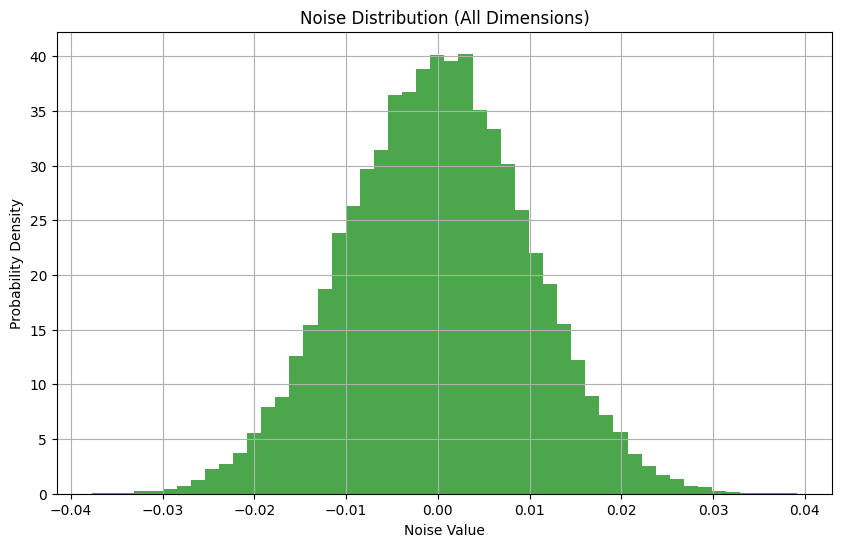

In [8]:
plt.figure(figsize=(10,6))
plt.hist(noise.flatten(), bins=50, density=True, alpha=0.7, color='green')
plt.title('Noise Distribution (All Dimensions)')
plt.xlabel('Noise Value')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

## Step 7: Plot Received vs Ideal Symbols (2D projections)
- Visualize received symbols around ideal points in X-Y and Y-Z planes.

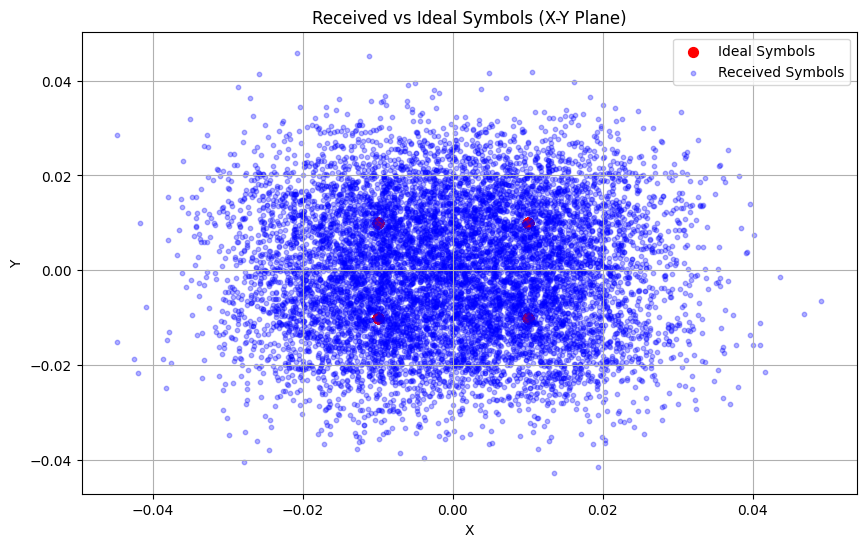

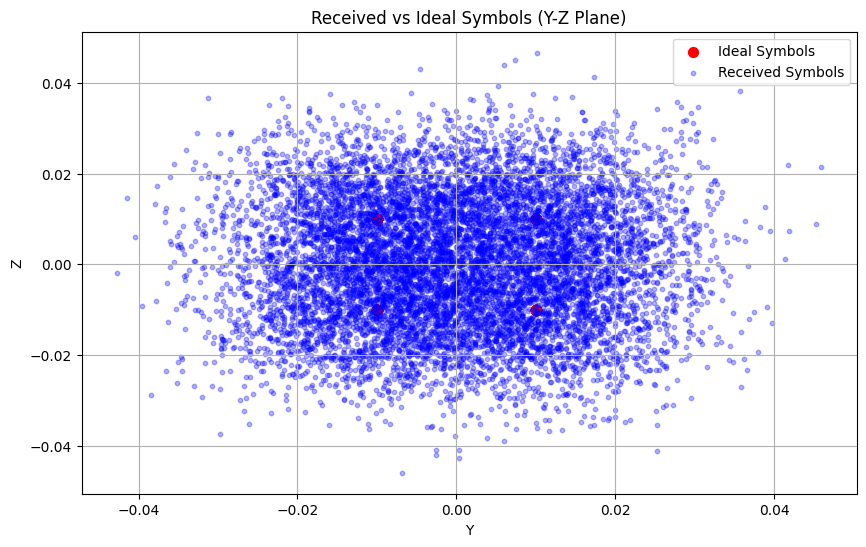

In [9]:
plt.figure(figsize=(10,6))
plt.scatter(tx_symbols[:,0], tx_symbols[:,1], c='red', label='Ideal Symbols', s=50)
plt.scatter(rx_symbols[:,0], rx_symbols[:,1], c='blue', alpha=0.3, label='Received Symbols', s=10)
plt.title('Received vs Ideal Symbols (X-Y Plane)')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(tx_symbols[:,1], tx_symbols[:,2], c='red', label='Ideal Symbols', s=50)
plt.scatter(rx_symbols[:,1], rx_symbols[:,2], c='blue', alpha=0.3, label='Received Symbols', s=10)
plt.title('Received vs Ideal Symbols (Y-Z Plane)')
plt.xlabel('Y')
plt.ylabel('Z')
plt.legend()
plt.grid(True)
plt.show()

## Step 8: 3D Visualization of Received Symbols
- 3D scatter plot shows received symbols vs ideal constellation points.

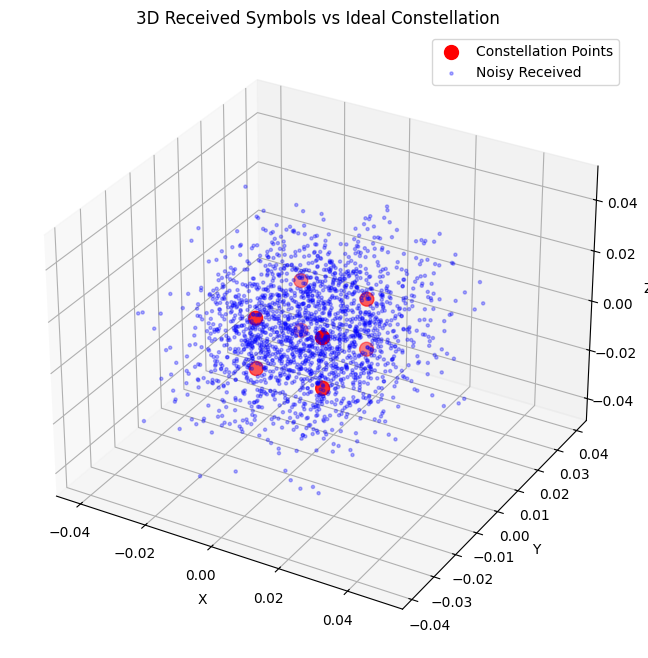

In [10]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(constellation_points[:,0], constellation_points[:,1], constellation_points[:,2],
           c='red', s=100, label='Constellation Points')
ax.scatter(rx_symbols[:2000,0], rx_symbols[:2000,1], rx_symbols[:2000,2],
           c='blue', s=5, alpha=0.3, label='Noisy Received')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Received Symbols vs Ideal Constellation')
ax.legend()
plt.show()